#  Minimum Spanning Tree Problem 
## Multicommodity flow formulation


In [1]:
import networkx as nx
import gurobipy as gb
from itertools import combinations, chain
import pygraphviz as pygv
import os
from IPython.display import SVG, display
import matplotlib.pyplot as plt


In [2]:
class args:
    filename = None
    scale = 40
    figsize = (6,6)
    
def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        

    
    #edges_in_sol = [(u,v)  for u,v in G.edges() if x[u,v].x > 0.1]

    
    plt.axis('off')
    plt.show()

In [4]:
args.filename = "network2.gml"
args.figsize = 10,12

basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 15 nodes and 105 edges


In [5]:
G = nx.convert_node_labels_to_integers(G, first_label=0,label_attribute='old' )

In [9]:
G.edges(data=True)

EdgeDataView([(0, 1, {'cost': 3569}), (0, 2, {'cost': 3716}), (0, 3, {'cost': 3801}), (0, 4, {'cost': 4104}), (0, 5, {'cost': 1236}), (0, 6, {'cost': 4775}), (0, 7, {'cost': 824}), (0, 8, {'cost': 2531}), (0, 9, {'cost': 200}), (0, 10, {'cost': 2617}), (0, 11, {'cost': 3981}), (0, 12, {'cost': 2683}), (0, 13, {'cost': 1702}), (0, 14, {'cost': 2213}), (1, 2, {'cost': 806}), (1, 3, {'cost': 854}), (1, 4, {'cost': 1081}), (1, 5, {'cost': 2507}), (1, 6, {'cost': 1345}), (1, 7, {'cost': 3624}), (1, 8, {'cost': 1044}), (1, 9, {'cost': 3613}), (1, 10, {'cost': 1345}), (1, 11, {'cost': 1004}), (1, 12, {'cost': 1208}), (1, 13, {'cost': 2473}), (1, 14, {'cost': 1979}), (2, 3, {'cost': 1649}), (2, 4, {'cost': 1838}), (2, 5, {'cost': 2842}), (2, 6, {'cost': 1104}), (2, 7, {'cost': 3940}), (2, 8, {'cost': 1421}), (2, 9, {'cost': 3801}), (2, 10, {'cost': 1969}), (2, 11, {'cost': 282}), (2, 12, {'cost': 1044}), (2, 13, {'cost': 2308}), (2, 14, {'cost': 2555}), (3, 4, {'cost': 316}), (3, 5, {'cost': 2

In [10]:
pos = {i:(G.nodes[i]['x'] * args.scale,G.nodes[i]['y'] * args.scale) for i in G.nodes()}

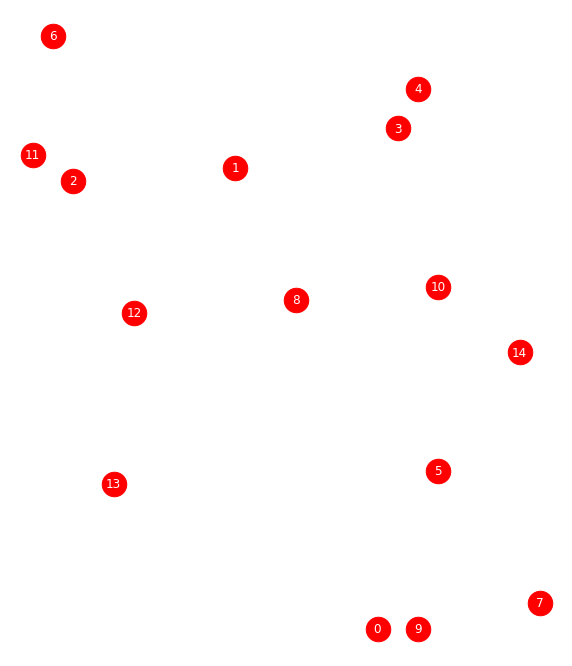

In [11]:
DrawInitG(G)

## Decision variables

$$
x_e = \begin{cases}
1 \text{ if edge $e$ is in the tree} \\
0 \text { otherwise}
\end{cases}
$$

Associate to each edge $e$ two directed arcs $(i,j)$ and $(j,i)$ and let 


$$
y_{ij}= \{\text{capacity for the flow of each commodity $k$ in arc } (i,j)\}
$$

$$
f^k_{ij} = \{\text{flow of commodity $k$ carried by the arc } (i,j)\}
$$


$$
z^h_{i} = \begin{cases}
1 \text{ if hub of type $h$ is installed in node $i$} \\
0 \text { otherwise}
\end{cases}
$$

In [149]:
G.nodes()
root = 0

In [150]:
D = G.to_directed()

In [151]:
mstmulti = gb.Model()

In [152]:
x = mstmulti.addVars(G.edges(), obj=[G[u][v]['cost'] for u,v in G.edges()],\
                    ub = 1.0,\
                    vtype=gb.GRB.BINARY,\
                    name='x')


In [153]:
y = mstmulti.addVars(D.edges(), \
                         ub=1.0, vtype=gb.GRB.BINARY,\
                         name='y')

In [154]:
commodities = list(G.nodes())[1:]
commodities

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [155]:
f = mstmulti.addVars(D.edges(), \
                         commodities, \
                         ub=G.number_of_nodes(), \
                         vtype=gb.GRB.CONTINUOUS, \
                         name='f')

In [156]:
hub_types = [1,2,3]
hub_cost = {1:15, 2:20, 3:50}



In [157]:
obj = [hub_cost[i] for j in G.nodes() for i in hub_types]

In [158]:
z = mstmulti.addVars (G.nodes(), 
                      hub_types,
                      obj=[hub_cost[i] for j in G.nodes() for i in hub_types],
                      vtype=gb.GRB.BINARY,
                      name='z')

In [159]:
mstmulti.write('multi.lp')

\begin{alignat}{3}
\min cx + \sum_{i \in V} \sum_{h \in HT} c_h z_i^h&&\\
\sum_{j \in \delta^+(0)} f^k_{0j} - \sum_{j \in \delta^-(0)} f^k_{j0} = 1 &&\;\; \forall k \not = \{0\}\\
\sum_{j \in \delta^-(v)} f^k_{jv} - \sum_{j \in \delta^+(v)} f^k_{vj} = 0 &&\;\; \forall k \not = \{0\}, \forall v \in V, v \not = \{0\}, v \not = k \\
\sum_{j \in \delta^-(k)} f^k_{jk} - \sum_{j \in \delta^+(k)} f^k_{kj} = 1 && \;\; \forall k \not = \{0\} \\
f^k_{ij} \le y_{ij} && \;\; \forall (i,j) \text{ and } \forall k \not = \{0\}\\
\sum_{\{i,j\} \in E} (y_{ij} + y_{ji}) = n-1\\
y_{ij} + y_{ji} = x_e && \\
\sum_{h \in HT} z_i^h = 1 \; \forall i  \in V\\
\sum_{e \in \delta(i)} x_e \le 2z_i^1 + 4 z_i^2 + 8 z_i^3 \;\; \forall i \in V\\
f \ge 0, \; x_e \in \{0,1\}\; 
\forall e \in E, \\ z_i^k \in \{0,1\} \; \forall i \in V, k \in HT \\y_{ij} \in \{0,1\} \; \forall (i,j) \in A
\end{alignat}

In [160]:
# ROOT CONSTRAINTS: there is one constraint for each commodity

for k in commodities:
    name = "Root_Com_"+str(k)
    mstmulti.addConstr(f.sum(root, '*', k) - \
                           f.sum('*',root,k) \
                           == 1, name)

mstmulti.update()

In [161]:
mstmulti.write('multi.lp')

In [162]:
# BALANCE CONSTRAINTS: written for all nodes different from root and for nodes different
# from the terminal of each commodity

for v in commodities:
    for k in commodities:
        if (v != k):
            name = "Balance_"+str(v)+"_Com_"+str(k)
            mstmulti.addConstr(f.sum('*',v,k) - f.sum(v,'*',k) == 0, name)
            

mstmulti.update()


In [163]:
mstmulti.write('multi.lp')

In [164]:
# TERMINAL CONSTRAINTS: there is one constraint for each commodity

for k in commodities:
    name = "Term_Com_"+str(k)
    mstmulti.addConstr(f.sum('*',k,k) - f.sum(k,'*',k) == 1, name)

mstmulti.update()


In [165]:
mstmulti.write('multi.lp')

In [166]:
# VARIABLE CAPACITY constraints

for k in commodities:
    for i,j in D.edges():
        name = "Cap_(%d,%d)" % (i,j) + "_Com_" + str(k)
        mstmulti.addConstr (f [i,j,k] - y[i,j] <= 0, name)

mstmulti.update()


In [167]:
mstmulti.write('multi.lp')

In [168]:
# CARDINALITY constraint

mstmulti.addConstr(y.sum() == G.number_of_nodes() - 1, "Cardinality")

mstmulti.update()

In [169]:
# EQUALITY constraints

for i,j in G.edges():
 
    name = "Equality_x_(%d,%d)"%(i,j)
    mstmulti.addConstr(y[i,j] + y[j,i] -  x[i,j] == 0, name)
    
mstmulti.update()

In [170]:
# In each node a hub must be installed 

for i in G.nodes():
    name = "Hub_%d" % i 
    mstmulti.addConstr (z.sum(i) == 1, name)

mstmulti.update()



In [171]:
gb.quicksum([x[u,v] if (u,v) in x else x[v,u] for u,v in G.edges(i)]) +  2*z[i, 1] + 4 * z[i, 2] + 8 * z[i, 3]

<gurobi.LinExpr: x[0,14] + x[1,14] + x[2,14] + x[3,14] + x[4,14] + x[5,14] + x[6,14] + x[7,14] + x[8,14] + x[9,14] + x[10,14] + x[11,14] + x[12,14] + x[13,14] + 2.0 z[14,1] + 4.0 z[14,2] + 8.0 z[14,3]>

In [172]:
for i in G.nodes():
    name = "Variable_Degree%d" % i
    mstmulti.addConstr(gb.quicksum([x[u,v] if (u,v) \
                                    in x else x[v,u] for u,v in G.edges(i)]) -  2*z[i, 1] - 4 * z[i, 2] - 8 * z[i, 3], \
                  sense='<=', rhs=0, name=name)

In [173]:
mstmulti.write('multi.lp')

In [174]:
mstmulti.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3286 rows, 3300 columns and 12585 nonzeros
Model fingerprint: 0xe4db656e
Variable types: 2940 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [2e+01, 5e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+01]
Presolve removed 0 rows and 15 columns
Presolve time: 0.01s
Presolved: 3286 rows, 3285 columns, 12555 nonzeros
Variable types: 2940 continuous, 345 integer (345 binary)
Found heuristic solution: objective 29284.000000

Root relaxation: objective 1.082700e+04, 1461 iterations, 0.06 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 10827.0000    0    2 29284.0000 10827.0000  63.0%     -    0s
H    0     0                    10832.0

Optimal solution: 10832.0


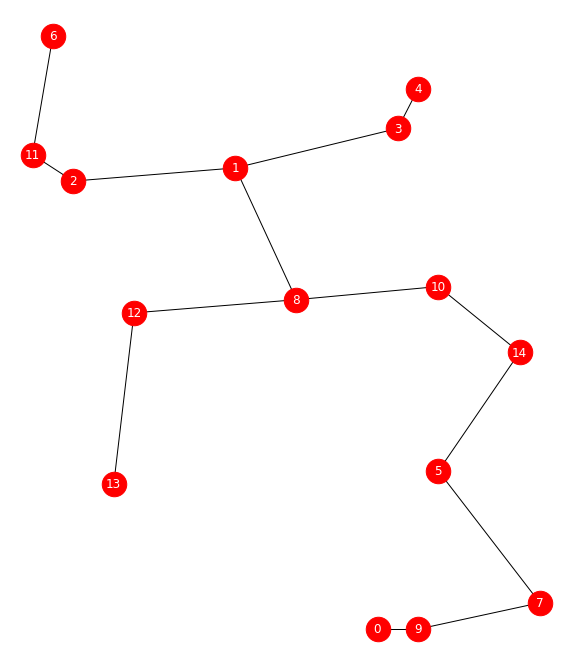

In [175]:
print ("Optimal solution:", mstmulti.objVal)
DrawSol(G,x)


In [176]:
z

{(0, 1): <gurobi.Var z[0,1] (value 1.0)>,
 (0, 2): <gurobi.Var z[0,2] (value -0.0)>,
 (0, 3): <gurobi.Var z[0,3] (value -0.0)>,
 (1, 1): <gurobi.Var z[1,1] (value 0.0)>,
 (1, 2): <gurobi.Var z[1,2] (value 1.0)>,
 (1, 3): <gurobi.Var z[1,3] (value -0.0)>,
 (2, 1): <gurobi.Var z[2,1] (value 1.0)>,
 (2, 2): <gurobi.Var z[2,2] (value 0.0)>,
 (2, 3): <gurobi.Var z[2,3] (value -0.0)>,
 (3, 1): <gurobi.Var z[3,1] (value 1.0)>,
 (3, 2): <gurobi.Var z[3,2] (value -0.0)>,
 (3, 3): <gurobi.Var z[3,3] (value -0.0)>,
 (4, 1): <gurobi.Var z[4,1] (value 1.0)>,
 (4, 2): <gurobi.Var z[4,2] (value -0.0)>,
 (4, 3): <gurobi.Var z[4,3] (value -0.0)>,
 (5, 1): <gurobi.Var z[5,1] (value 1.0)>,
 (5, 2): <gurobi.Var z[5,2] (value -0.0)>,
 (5, 3): <gurobi.Var z[5,3] (value -0.0)>,
 (6, 1): <gurobi.Var z[6,1] (value 1.0)>,
 (6, 2): <gurobi.Var z[6,2] (value -0.0)>,
 (6, 3): <gurobi.Var z[6,3] (value -0.0)>,
 (7, 1): <gurobi.Var z[7,1] (value 1.0)>,
 (7, 2): <gurobi.Var z[7,2] (value -0.0)>,
 (7, 3): <gurobi.Var 